# **Hackday 2° Edicao - Classificação**

# 0.0. IMPORTS

In [49]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [3]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.float_format', '{:.2f}'.format)
    
    sns.set()

In [4]:
jupyter_settings()

## 0.2. Loading data

In [5]:
df_train_raw = pd.read_csv( 'data/train.csv' )
df_test_raw = pd.read_csv('data/test.csv')

# 1.0. DESCRICAO DOS DADOS

In [6]:
df1 = df_train_raw.copy()

In [7]:
df1.head()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
0,1767,21,278.17,2577.05,24196.90,104.31,31.04,6,5,7,21,14,9,15,Não,Não,Negar
1,11920,40,268.87,2465.39,19227.38,69.86,36.92,5,8,5,40,23,10,18,Não,Não,Negar
2,8910,36,446.64,1055.29,42822.28,134.20,34.56,0,3,6,26,13,3,15,Sim,Não,Negar
3,4964,58,321.14,703.05,51786.83,297.35,31.49,0,3,7,12,7,2,1,Sim,Não,Negar
4,10100,35,428.72,891.29,44626.85,134.20,28.03,2,8,7,24,10,8,20,Sim,Não,Negar


## 1.1. Rename Columns

In [7]:
# cols_old = df1.columns.values

# snakecase = lambda x: inflection.underscore( x )

# cols_new = list( map( snakecase, cols_old ) )

# # rename
# df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 9500
Number of Cols: 17


## 1.3. Data Types

In [9]:
df1.dtypes

id_cliente                   int64
idade                        int64
saldo_atual                float64
divida_atual               float64
renda_anual                float64
valor_em_investimentos     float64
taxa_utilizacao_credito    float64
num_emprestimos              int64
num_contas_bancarias         int64
num_cartoes_credito          int64
dias_atraso_dt_venc          int64
num_pgtos_atrasados          int64
num_consultas_credito        int64
taxa_juros                   int64
investe_exterior            object
pessoa_polit_exp            object
limite_adicional            object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

id_cliente                 0
idade                      0
saldo_atual                0
divida_atual               0
renda_anual                0
valor_em_investimentos     0
taxa_utilizacao_credito    0
num_emprestimos            0
num_contas_bancarias       0
num_cartoes_credito        0
dias_atraso_dt_venc        0
num_pgtos_atrasados        0
num_consultas_credito      0
taxa_juros                 0
investe_exterior           0
pessoa_polit_exp           0
limite_adicional           0
dtype: int64

## 1.5. Fillout NA

## 1.6. Change Data Types

In [11]:
df1.dtypes

id_cliente                   int64
idade                        int64
saldo_atual                float64
divida_atual               float64
renda_anual                float64
valor_em_investimentos     float64
taxa_utilizacao_credito    float64
num_emprestimos              int64
num_contas_bancarias         int64
num_cartoes_credito          int64
dias_atraso_dt_venc          int64
num_pgtos_atrasados          int64
num_consultas_credito        int64
taxa_juros                   int64
investe_exterior            object
pessoa_polit_exp            object
limite_adicional            object
dtype: object

## 1.7. Descriptive Statistics

In [13]:
num_attributes, cat_attributes = df1.select_dtypes( include=['int64', 'float64'] ), df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Atributes

In [14]:
desc_stats = pd.concat([num_attributes.describe(), pd.DataFrame([num_attributes.skew(), num_attributes.kurtosis()], index=['skew', 'kurtosis'])], axis=0).T
desc_stats

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
id_cliente,9500.00,6210.53,3603.24,1.00,3091.75,6172.50,9320.25,12500.00,0.01,-1.20
idade,9500.00,126.40,685.04,18.00,28.00,38.00,47.00,8598.00,9.09,87.61
saldo_atual,9500.00,404.53,217.70,0.09,272.36,337.17,471.26,1602.04,1.62,3.10
divida_atual,9500.00,1437.09,1156.26,0.23,573.62,1175.73,1963.33,4998.07,1.19,0.85
renda_anual,9500.00,195037.27,1454273.73,10473.87,26207.90,45991.11,80449.83,23279657.98,11.87,149.39
valor_em_investimentos,9500.00,612.00,2002.44,0.00,76.08,134.20,249.18,10000.00,4.44,17.87
taxa_utilizacao_credito,9500.00,32.27,5.11,20.99,28.08,32.26,36.46,49.56,0.04,-0.92
num_emprestimos,9500.00,10.86,62.56,0.00,2.00,3.00,6.00,1496.00,16.37,310.98
num_contas_bancarias,9500.00,17.55,120.98,0.00,3.00,6.00,7.00,1779.00,10.88,123.22
num_cartoes_credito,9500.00,21.43,122.68,1.00,4.00,6.00,7.00,1479.00,8.56,76.79


### 1.7.2. Categorical Atributes

In [15]:
cat_attributes.apply( lambda x: x.nunique() )

investe_exterior    2
pessoa_polit_exp    2
limite_adicional    2
dtype: int64

Criar boxplots para cada variável categórica X variável target.

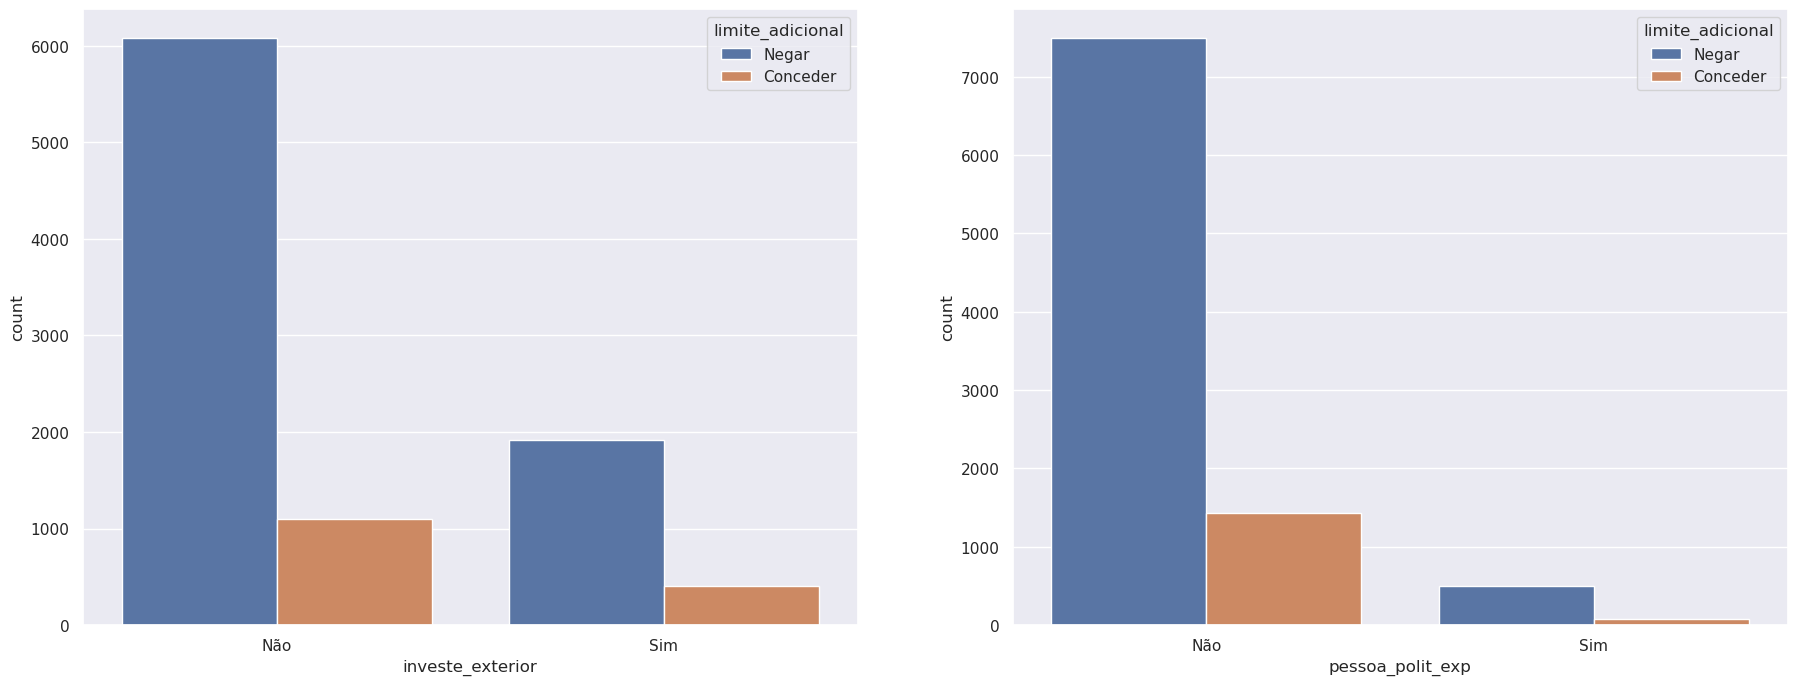

In [16]:
fig, ax  = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))

sns.countplot(x='investe_exterior', hue='limite_adicional', data=df1, ax=ax[0])
sns.countplot(x='pessoa_polit_exp', hue='limite_adicional', data=df1, ax=ax[1])

plt.show()

# 2.0. FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

In [50]:
#Image( 'img/MindMapHypothesis.png' )

## 2.2. Criacao das Hipoteses

### 2.2.1. Hipoteses *Agente 1*

### 2.2.2. Hipoteses *Agente 2*

### 2.2.3. Hipoteses *Agente 3*

## 2.3. Lista Final de Hipóteses

## 2.4. Feature Engineering

In [19]:
for col in df2.columns:
    print(f"{col}: {df2[col].nunique()}")

id_cliente: 9500
idade: 236
saldo_atual: 9408
divida_atual: 9330
renda_anual: 9492
valor_em_investimentos: 8623
taxa_utilizacao_credito: 9500
num_emprestimos: 58
num_contas_bancarias: 132
num_cartoes_credito: 205
dias_atraso_dt_venc: 73
num_pgtos_atrasados: 95
num_consultas_credito: 154
taxa_juros: 205
investe_exterior: 2
pessoa_polit_exp: 2
limite_adicional: 2


In [20]:
map1 = {
    'Não': 0,
    'Sim': 1
}

df2['investe_exterior'] = df2['investe_exterior'].map(map1)

In [21]:
map2 = {
    'Não': 0,
    'Sim': 1
}

df2['pessoa_polit_exp'] = df2['pessoa_polit_exp'].map(map2)

In [22]:
map3 = {
    'Negar': 0,
    'Conceder': 1
}

df2['limite_adicional'] = df2['limite_adicional'].map(map3)

# 3.0. FILTRAGEM DE VARIÁVEIS

In [23]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas


## 3.2. Selecao das Colunas

In [67]:
# cols_drop = []
# df3 = df3.drop(columns=cols_drop)

# 4.0. ANALISE EXPLORATORIA DE DADOS

In [24]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

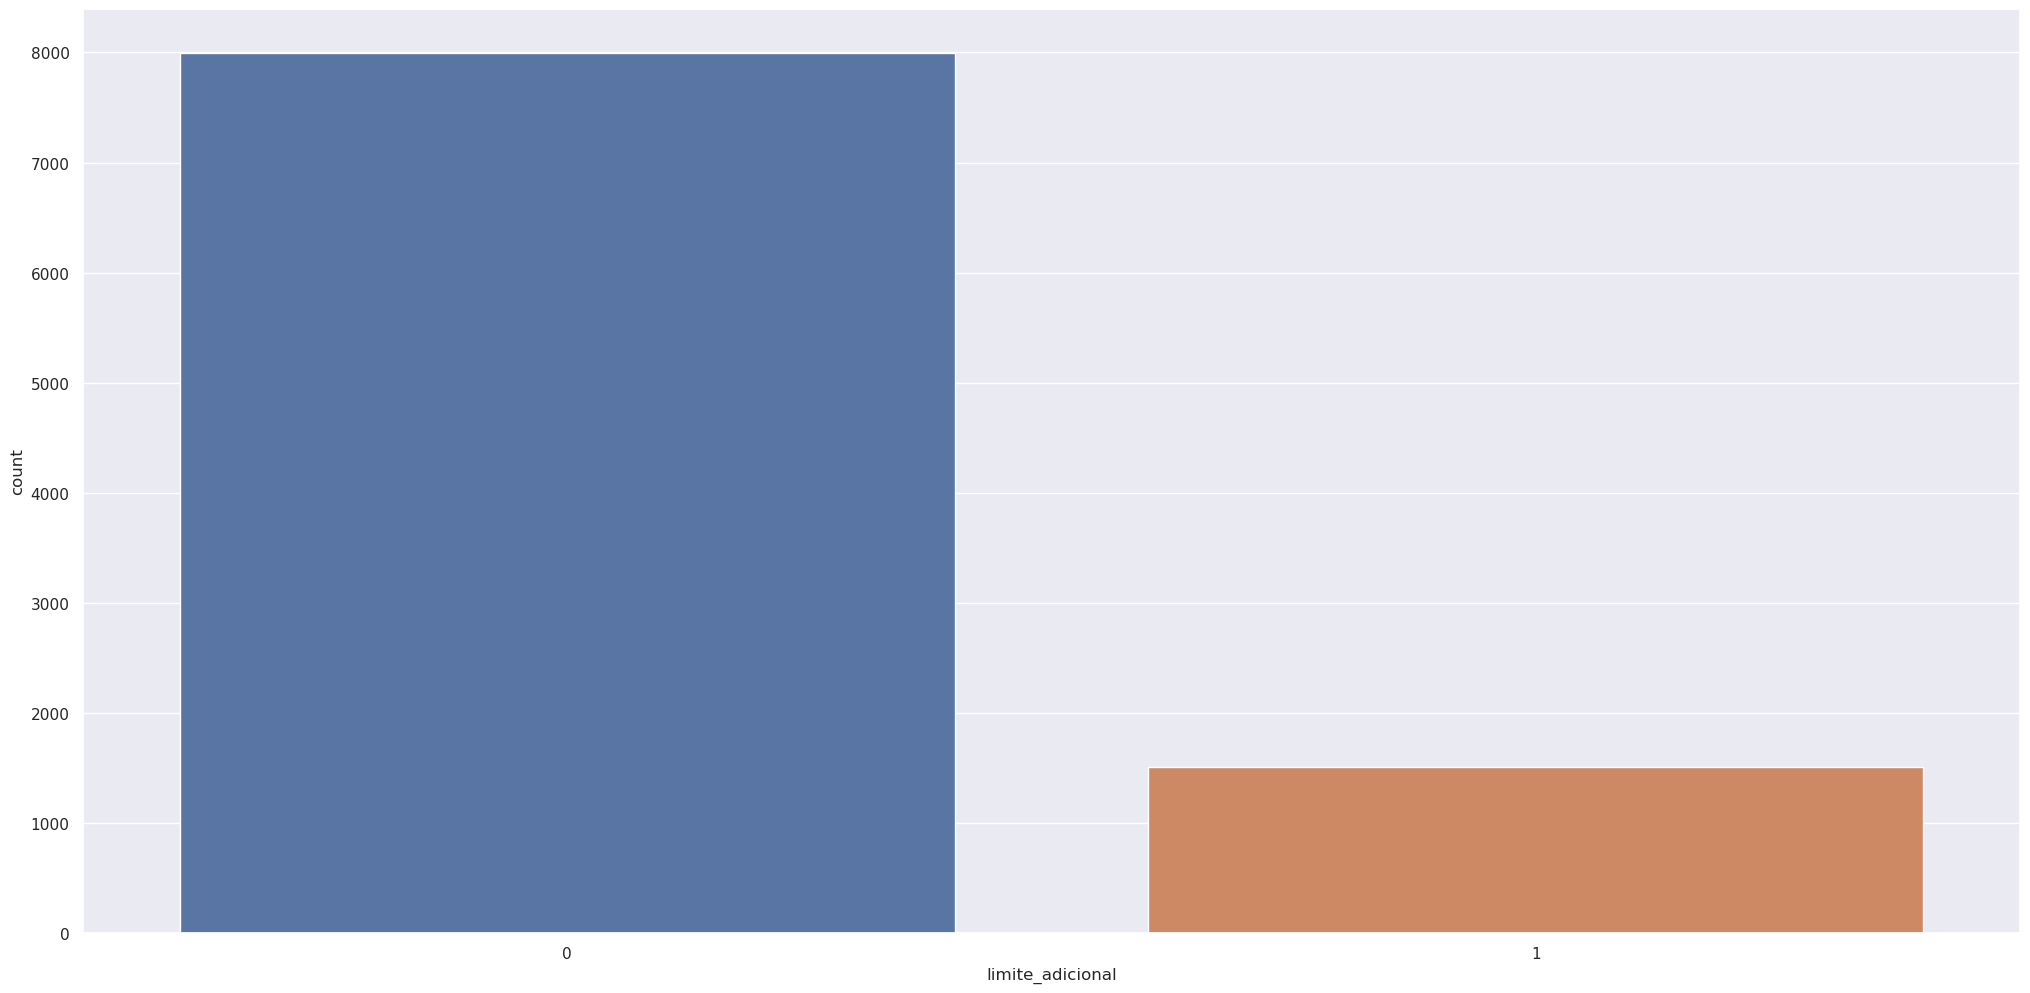

In [36]:
sns.countplot(x='limite_adicional', data=df4)

### 4.1.2. Numerical Variable

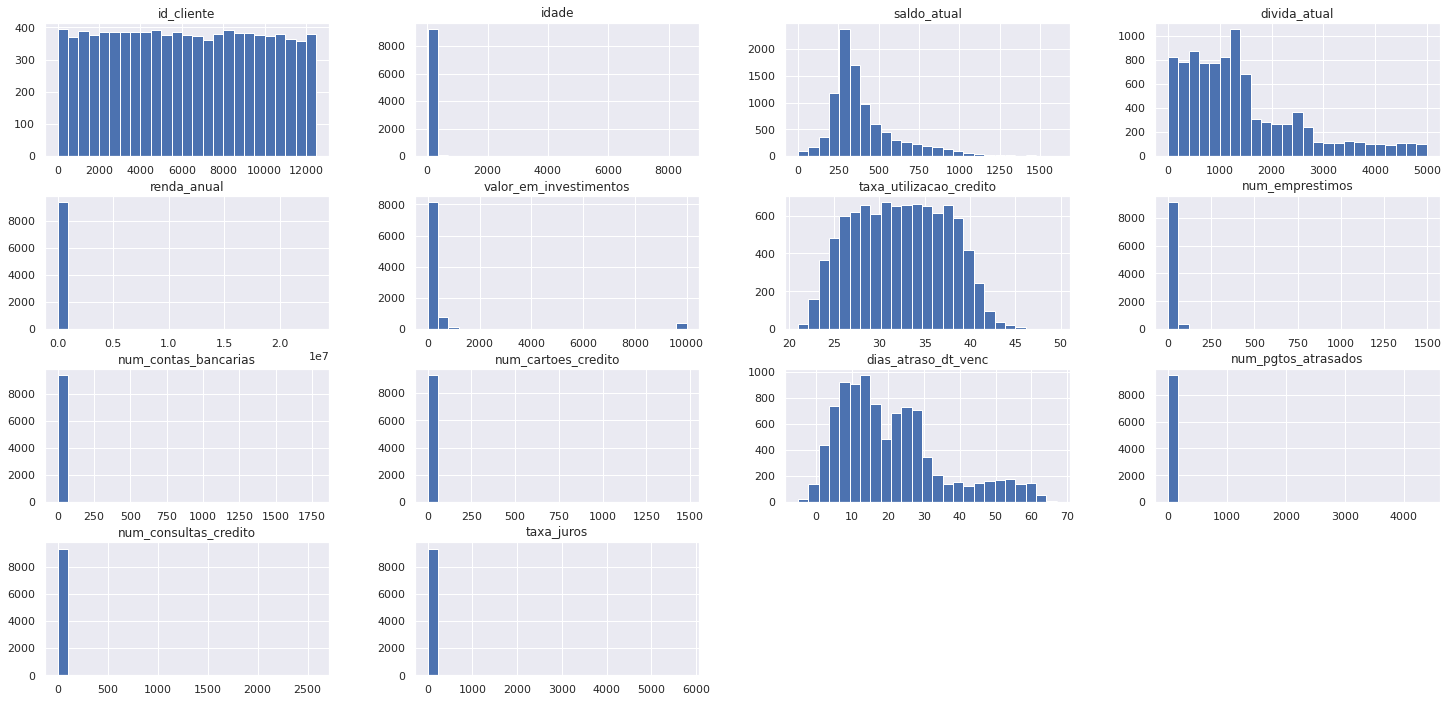

In [75]:
num_attributes.hist( bins=25 );

<AxesSubplot:xlabel='idade'>

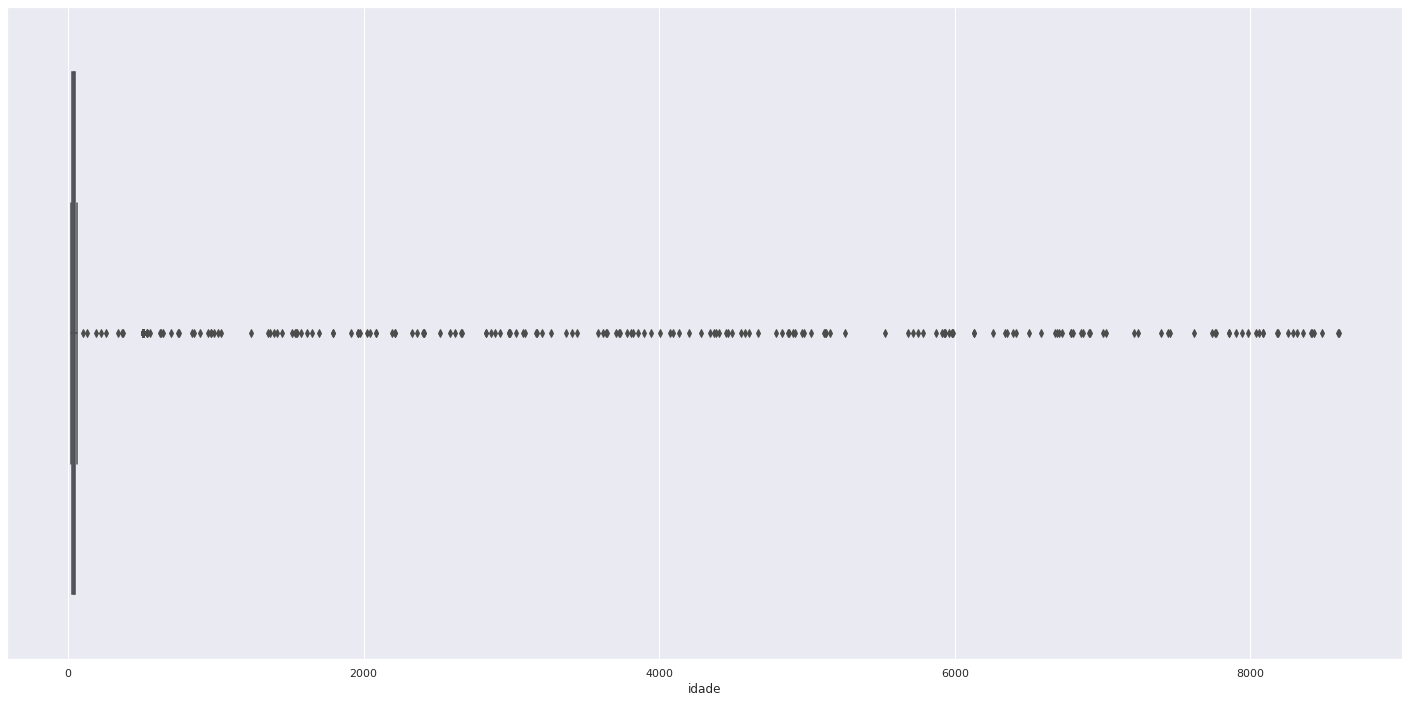

In [77]:
sns.boxplot(df4['idade'])


### 4.1.3. Categorical Variable

In [ ]:
# # Printa countplot + kdeplot para cada variável categórica e seus níveis
# # cat1
# plt.subplot( 3, 2, 1 )
# a = df4[df4['cat1'] != 'nvl0']
# sns.countplot( a['cat1'] )

# plt.subplot( 3, 2, 2 )
# sns.kdeplot( df4[df4['cat1'] == 'nvl1']['target_variable'], label='nvl1', shade=True )
# sns.kdeplot( df4[df4['cat1'] == 'nvl2']['target_variable'], label='nvl1', shade=True )
# sns.kdeplot( df4[df4['cat1'] == 'nvl3']['target_variable'], label='nvl2', shade=True )

# # cat2
# plt.subplot( 3, 2, 3 )
# sns.countplot( df4['cat2'] )

# plt.subplot( 3, 2, 4 )
# sns.kdeplot( df4[df4['cat2'] == 'nvl1']['target_variable'], label='nvl1', shade=True )
# sns.kdeplot( df4[df4['cat2'] == 'nvl2']['target_variable'], label='nvl1', shade=True )
# sns.kdeplot( df4[df4['cat2'] == 'nvl3']['target_variable'], label='nvl2', shade=True )

# # cat3
# plt.subplot( 3, 2, 5 )
# sns.countplot( df4['cat3'] )

# plt.subplot( 3, 2, 6 )
# sns.kdeplot( df4[df4['cat3'] == 'nvl1']['target_variable'], label='nvl1', shade=True )
# sns.kdeplot( df4[df4['cat3'] == 'nvl2']['target_variable'], label='nvl1', shade=True )
# sns.kdeplot( df4[df4['cat3'] == 'nvl3']['target_variable'], label='nvl2', shade=True )

## 4.2. Analise Bivariada

## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

In [39]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

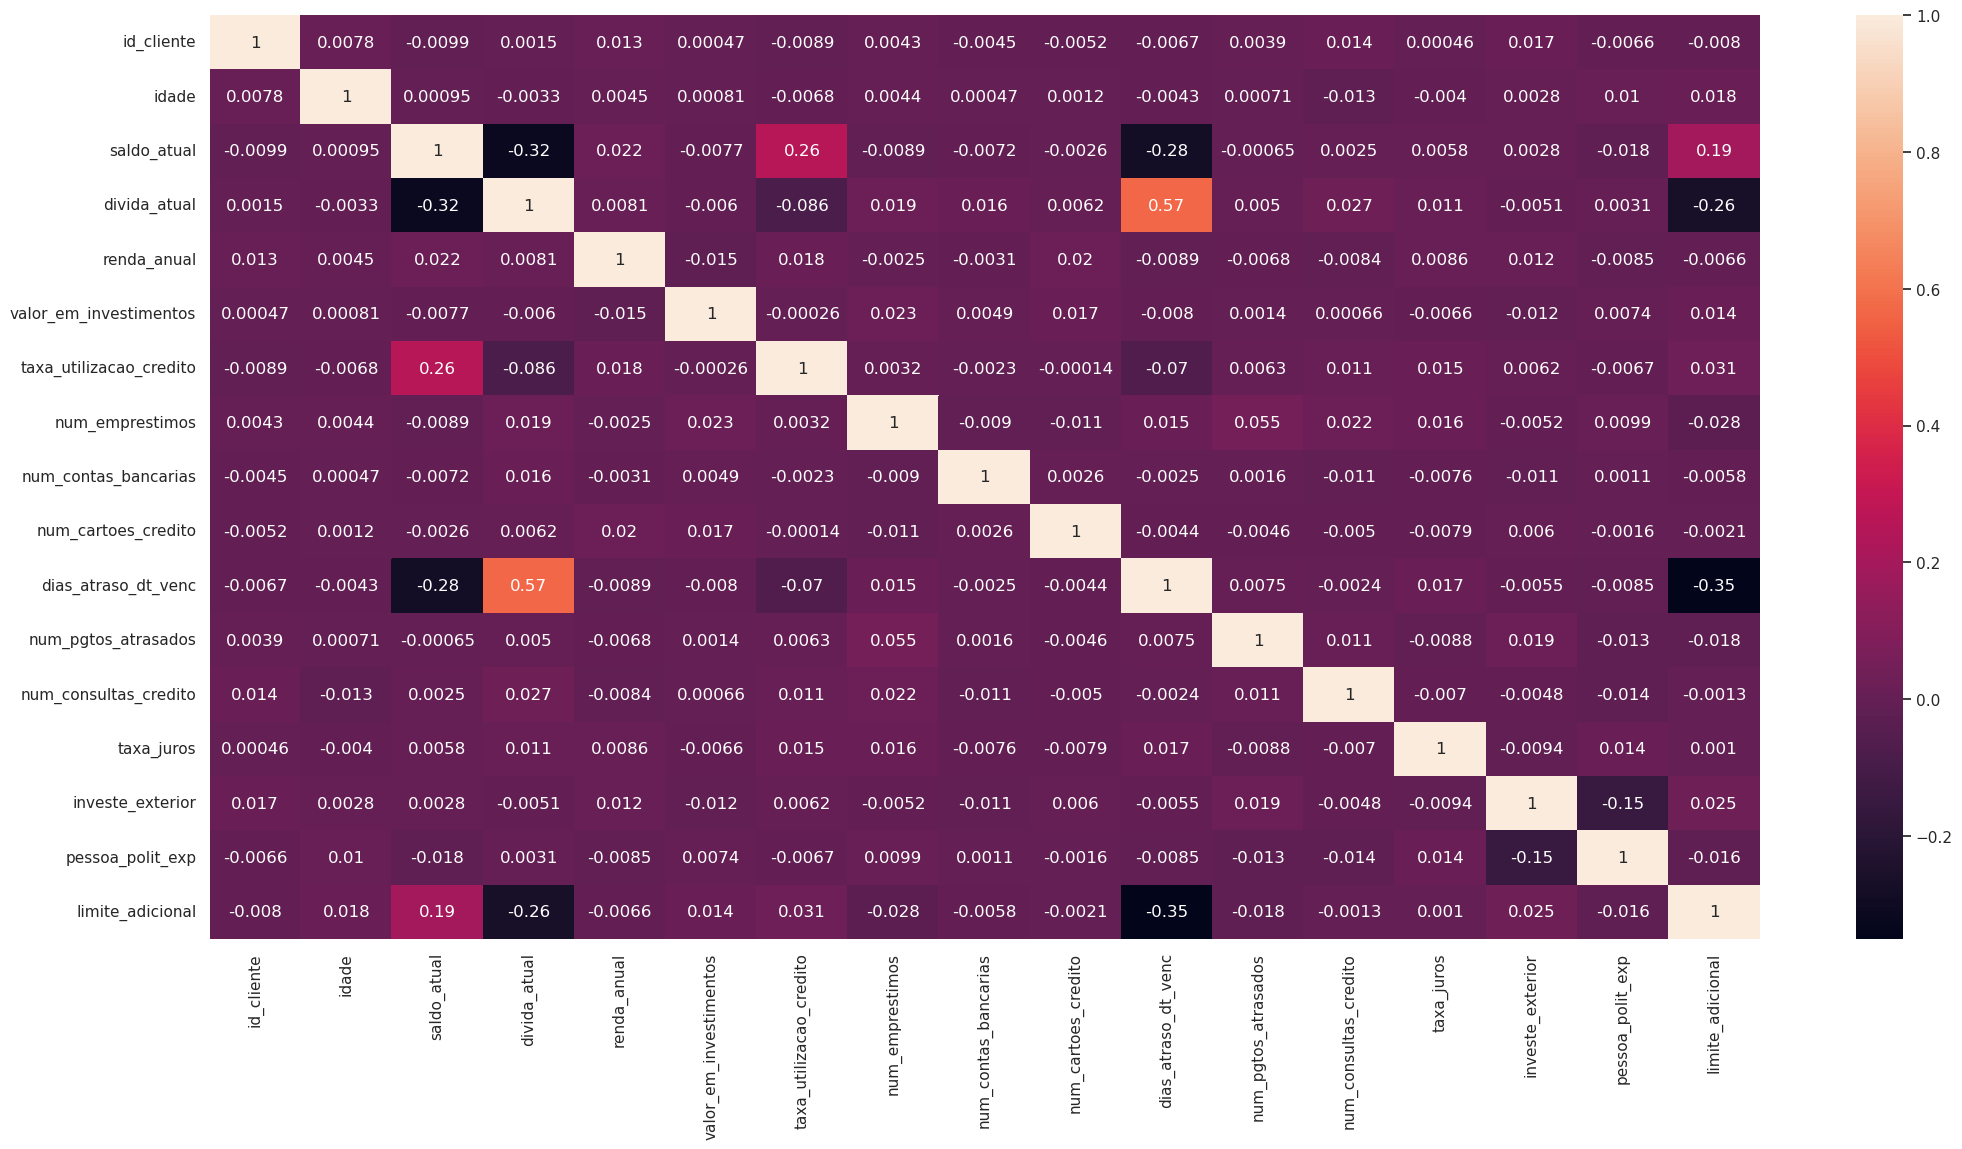

In [40]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

# 5.0. DATA PREPARATION

In [51]:
df5 = df4.copy()

## 5.1. Normalizacao

In [53]:
ss = StandardScaler()

# saldo_autal
df5['saldo_atual'] = ss.fit_transform( df5[['saldo_atual']].values )
pickle.dump( ss, open( 'parameter/saldo_atual_scaler.pkl', 'wb') )

# taxa_utilizacao_credito
df5['taxa_utilizacao_credito'] = ss.fit_transform( df5[['taxa_utilizacao_credito']].values )
pickle.dump( ss, open( 'parameter/taxa_utilizacao_credito_scaler.pkl', 'wb') )

## 5.2. Rescaling

In [477]:
rs = RobustScaler()
mms = MinMaxScaler()

## Robust Scaler
# idade
df5['idade'] = rs.fit_transform( df5[['idade']].values )
pickle.dump( rs, open( 'parameter/idade_scaler.pkl', 'wb') )

# renda_anual
df5['renda_anual'] = rs.fit_transform( df5[['renda_anual']].values )
pickle.dump( rs, open( 'parameter/renda_anual_scaler.pkl', 'wb') )

# valor_em_investimentos
df5['valor_em_investimentos'] = rs.fit_transform( df5[['valor_em_investimentos']].values )
pickle.dump( rs, open( 'parameter/valor_em_investimentos_scaler.pkl', 'wb') )

# num_emprestimos
df5['num_emprestimos'] = rs.fit_transform( df5[['num_emprestimos']].values )
pickle.dump( rs, open( 'parameter/num_emprestimos_scaler.pkl', 'wb') )

# num_contas_bancarias
df5['num_contas_bancarias'] = rs.fit_transform( df5[['num_contas_bancarias']].values )
pickle.dump( rs, open( 'parameter/num_contas_bancarias_scaler.pkl', 'wb') )

# num_cartoes_credito
df5['num_cartoes_credito'] = rs.fit_transform( df5[['num_cartoes_credito']].values )
pickle.dump( rs, open( 'parameter/num_cartoes_credito_scaler.pkl', 'wb') )

# num_pgtos_atrasados
df5['num_pgtos_atrasados'] = rs.fit_transform( df5[['num_pgtos_atrasados']].values )
pickle.dump( rs, open( 'parameter/num_pgtos_atrasados_scaler.pkl', 'wb') )

# num_consultas_credito
df5['num_consultas_credito'] = rs.fit_transform( df5[['num_consultas_credito']].values )
pickle.dump( rs, open( 'parameter/num_consultas_credito_scaler.pkl', 'wb') )

# taxa_juros
df5['taxa_juros'] = rs.fit_transform( df5[['taxa_juros']].values )
pickle.dump( rs, open( 'parameter/taxa_juros_scaler.pkl', 'wb') )

## MinMax Scaler
# dias_atraso_dt_venc
df5['dias_atraso_dt_venc'] = mms.fit_transform( df5[['dias_atraso_dt_venc']].values )
pickle.dump( rs, open( 'parameter/dias_atraso_dt_venc_scaler.pkl', 'wb') )

# divida_atual
df5['divida_atual'] = mms.fit_transform( df5[['divida_atual']].values )
pickle.dump( rs, open( 'parameter/divida_atual_scaler.pkl', 'wb') )

## 5.3. Transformacao

### 5.3.1. Encoding

In [475]:
# # state_holiday - One Hot Encoding
# df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# # store_type - Label Encoding
# le = LabelEncoder()
# df5['store_type'] = le.fit_transform( df5['store_type'] )
# pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# # assortment - Ordinal Encoding
# assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
# df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

In [48]:
# df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Nature Transformation

In [49]:
# # day of week
# df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
# df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# # month
# df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
# df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# # day 
# df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
# df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# # week of year
# df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
# df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0. FEATURE SELECTION

In [50]:
# df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [51]:
# cols_drop = [ ]
# df6 = df6.drop( columns=cols_drop )

In [ ]:
# # training dataset
# X_train = df6[df6['date'] < '2015-06-19']
# y_train = X_train['sales']

# # test dataset
# X_test = df6[df6['date'] >= '2015-06-19']
# y_test = X_test['sales']

# print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
# print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

# print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
# print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

## 6.2. Boruta as Feature Selector

In [53]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1. Best Features from Boruta

In [54]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [55]:
# cols_selected_boruta = [
#     'store',
#     'promo',
#     'store_type',
#     'assortment',
#     'competition_distance',
#     'competition_open_since_month',
#     'competition_open_since_year',
#     'promo2',
#     'promo2_since_week',
#     'promo2_since_year',
#     'competition_time_month',
#     'promo_time_week',
#     'day_of_week_sin',
#     'day_of_week_cos',
#     'month_sin',
#     'month_cos',
#     'day_sin',
#     'day_cos',
#     'week_of_year_sin',
#     'week_of_year_cos']

# # columns to add
# feat_to_add = ['date', 'sales']

# cols_selected_boruta_full = cols_selected_boruta.copy()
# cols_selected_boruta_full.extend( feat_to_add )

# 7.0. MACHINE LEARNING MODELLING

In [56]:
# x_train = X_train[ cols_selected_boruta ]
# x_test = X_test[ cols_selected_boruta ]

# # Time Series Data Preparation
# x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [57]:
# aux1 = x_test.copy()
# aux1['sales'] = y_test.copy()

# # prediction
# aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
# aux1 = pd.merge( aux1, aux2, how='left', on='store' )
# yhat_baseline = aux1['predictions']

# # performance
# baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
# baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [58]:
# # model
# lr = LinearRegression().fit( x_train, y_train )

# # prediction
# yhat_lr = lr.predict( x_test )

# # performance
# lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
# lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [59]:
# lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
# lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [60]:
# # model
# lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# # prediction
# yhat_lrr = lrr.predict( x_test )

# # performance
# lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
# lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1.  Lasso - Cross Validation

In [61]:
# lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
# lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [62]:
# # model
# rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# # prediction
# yhat_rf = rf.predict( x_test )

# # performance
# rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
# rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.622763,0.09996,1011.191561


### 7.4.1.  Random Forest Regressor - Cross Validation

In [63]:
# rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
# rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.68 +/- 219.1,0.12 +/- 0.02,1256.08 +/- 320.36


## 7.5. XGBoost Regressor

In [64]:
# # model
# model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                               n_estimators=100, 
#                               eta=0.01, 
#                               max_depth=10, 
#                               subsample=0.7,
#                               colsample_bytee=0.9 ).fit( x_train, y_train )

# # prediction
# yhat_xgb = model_xgb.predict( x_test )

# # performance
# xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
# xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,843.112292,0.122609,1250.952634


### 7.5.1. XGBoost Regressor - Cross Validation

In [65]:
# xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
# xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [66]:
# modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
# modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.622763,0.099960,1011.191561
0,XGBoost Regressor,843.112292,0.122609,1250.952634
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2. Real Performance - Cross Validation

In [67]:
# modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
# modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,837.68 +/- 219.1,0.12 +/- 0.02,1256.08 +/- 320.36
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [68]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [69]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#
#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
#        
#final_result

In [70]:
#final_result

## 8.2. Final Model

In [71]:
# param_tuned = {
#     'n_estimators': 3000,
#     'eta': 0.03,
#     'max_depth': 5,
#     'subsample': 0.7,
#     'colsample_bytree': 0.7,
#     'min_child_weight': 3 
#         }

In [72]:
# # model
# model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
#                                     n_estimators=param_tuned['n_estimators'], 
#                                     eta=param_tuned['eta'], 
#                                     max_depth=param_tuned['max_depth'], 
#                                     subsample=param_tuned['subsample'],
#                                     colsample_bytee=param_tuned['colsample_bytree'],
#                                     min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# # prediction
# yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# # performance
# xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
# xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,664.974996,0.097529,957.774225


In [73]:
# mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
# mpe

-0.0035453341443739675

# 9.0. TRADUCAO E INTERPRETACAO DO ERRO

In [435]:
# df9 = X_test[ cols_selected_boruta_full ]

# # rescale
# df9['sales'] = np.expm1( df9['sales'] )
# df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [443]:
# # sum of predictions
# df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# # MAE and MAPE
# df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
# df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# # Merge
# df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
# df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# # Scenarios
# df92['worst_scenario'] = df92['predictions'] - df92['MAE']
# df92['best_scenario'] = df92['predictions'] + df92['MAE']

# # order columns
# df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [446]:
# df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104033.078125,100714.973723,107351.182527,3318.104402,0.565828
908,909,238233.875000,230573.337190,245894.412810,7660.537810,0.520433
875,876,203030.156250,199110.952435,206949.360065,3919.203815,0.305099
721,722,353005.781250,351013.625224,354997.937276,1992.156026,0.268338
594,595,400883.625000,397415.263170,404351.986830,3468.361830,0.242192


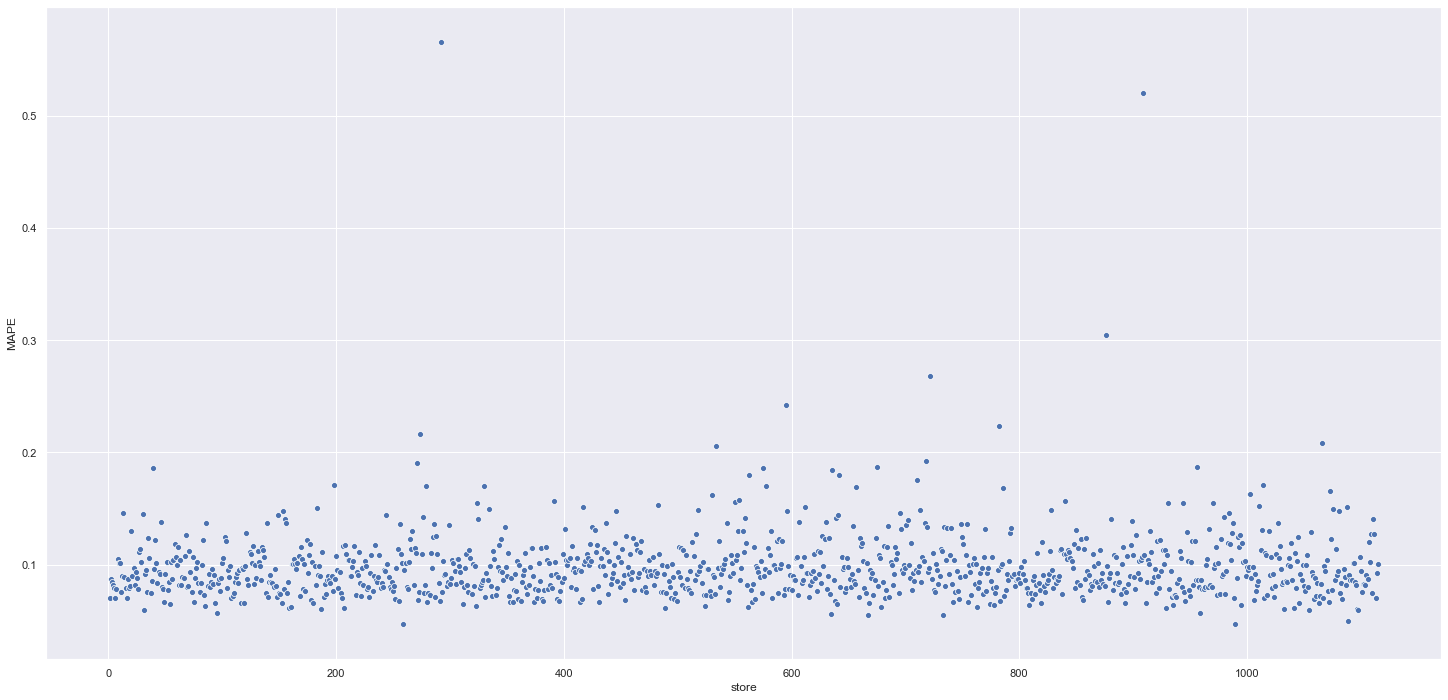

In [448]:
# sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2. Total Performance

In [455]:
# df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
# df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
# df93

,Scenario,Values
0,predictions,"R$285,860,497.77"
1,worst_scenario,"R$285,115,015.71"
2,best_scenario,"R$286,605,979.84"


## 9.3. Machine Learning Performance

In [457]:
# df9['error'] = df9['sales'] - df9['predictions']
# df9['error_rate'] = df9['predictions'] / df9['sales']

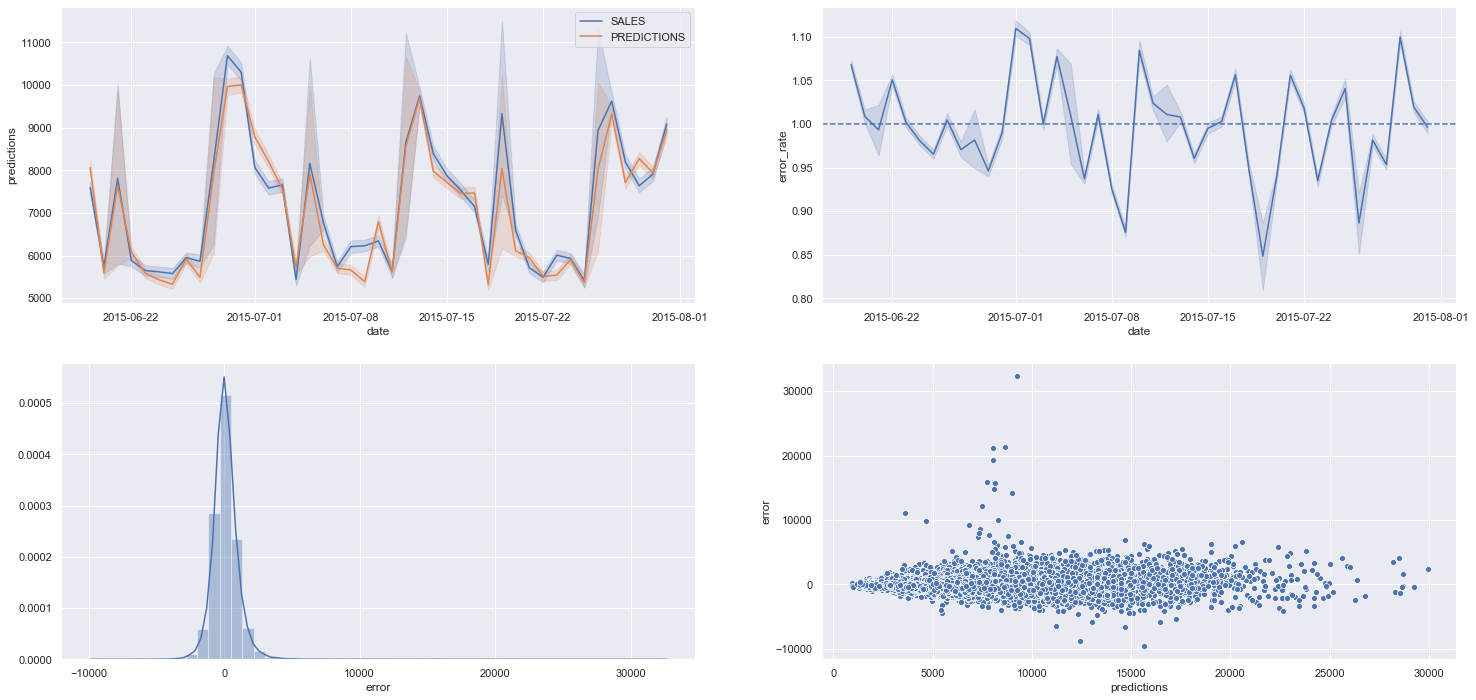

In [459]:
# plt.subplot( 2, 2, 1 )
# sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
# sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

# plt.subplot( 2, 2, 2 )
# sns.lineplot( x='date', y='error_rate', data=df9 )
# plt.axhline( 1, linestyle='--')

# plt.subplot( 2, 2, 3 )
# sns.distplot( df9['error'] )

# plt.subplot( 2, 2, 4 )
# sns.scatterplot( df9['predictions'], df9['error'] )

# 10.0. Kaggle Submission

In [ ]:
# # Save Trained Model
# pickle.dump( model_xgb_tuned, open( '/Users/meigarom/repos/DataScience_Em_Producao/model/model_rossmann.pkl', 'wb' ) )